# A 1D example with Normal modes

In this example we will solve the classic error free SOLA problem in 1D:
$$
\begin{gather}
    \nonumber \text{Given the data constraint} \\ 
    d_i = G(m) = \int_0^1 K_i(x) m(x) dx \\
    \nonumber \text{We want to find} \\
    p_i = T(m) = \int_0^1 \Tau_i(x) m(x) dx
\end{gather}
$$

First we import the needed modules

In [1]:
from sola.main_classes.spaces import RN, PCb
from sola.main_classes.domains import HyperParalelipiped
from sola.main_classes.mappings import *
from sola.main_classes import functions

import matplotlib.pyplot as plt

# This contains various functions for loading and handling normal mode data
from sola.aux.normal_data import *

Then we import the kernel data

In [2]:
# Directory where all the data is and whether we want vs or vp etc
data_directory = 'kernels_modeplotaat_Adrian'
kernel_type = 'vp'
# Read the file that contains all available modes
kernel_discrete_domain, discrete_sensitivity_kernels = load_normal_data(kernel_type, data_directory)

This data is, however, discrete. We need the sensitivity kernels to be functions defined on a continuous domain. We create interpolation functions based on the discrete sensitivity kernels using the Interpolation_1D class in functions.py. (Important discussion: what errors are introduced by the discreteness of the sensitivity kernels and the choice of interpolation for it?)

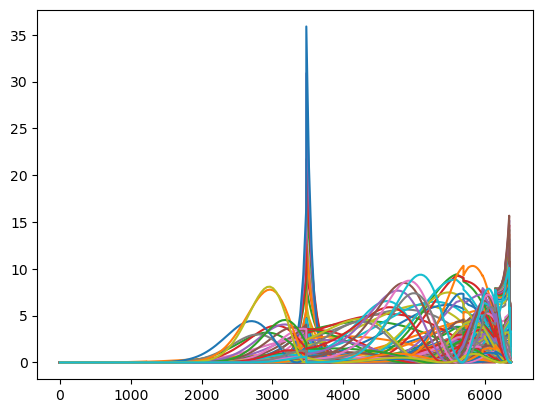

In [3]:
%matplotlib inline
# Create Earth 1D domain
EarthDomain = HyperParalelipiped(bounds=[[kernel_discrete_domain[0],
                                          kernel_discrete_domain[-1]]],
                                          fineness=1000)

sensitivity_kernels = []
how_many_kernels_to_load = 100#len(discrete_sensitivity_kernels)
for i, discrete_sensitivity_kernel in enumerate(discrete_sensitivity_kernels[0:how_many_kernels_to_load]):
    sensitivity_kernels.append(functions.Interpolation_1D(values=discrete_sensitivity_kernel,
                                                            raw_domain=kernel_discrete_domain,
                                                            domain=EarthDomain))
    plt.plot(kernel_discrete_domain, discrete_sensitivity_kernel)

Then we create the needed spaces

In [4]:
# Create Model space
M = PCb(domain=EarthDomain)
# Create Data space (must know number of sensitivity kernels)
D = RN(dimension=how_many_kernels_to_load)
# Create Property space (must know number of target kernels)
no_targets = 100  # Number of targets we will use
P = RN(dimension=no_targets)


And the mappings. For the property mapping we also need to create some target kernels. 

In [5]:
# Create Data mapping (must have the sensitivity kernels)
G = IntegralMapping(domain=M, codomain=D, kernels=sensitivity_kernels)

# Create Target kernels
width = 1000 # same units as domain (km here)
enquiry_points = np.linspace(EarthDomain.bounds[0][0],
                             EarthDomain.bounds[0][1],
                             no_targets) # these are the locations where we center our targets

target_kernels = []
for i in range(no_targets):
    target_kernels.append(functions.Gaussian_1D(domain=EarthDomain,
                                                center=enquiry_points[i],
                                                width=width))
# You can also try to replace Gaussian_1D with Boxcar_1D or DGaussian_1D
T = IntegralMapping(domain=M, codomain=P, kernels=target_kernels)

Now we generate some fake true model and data

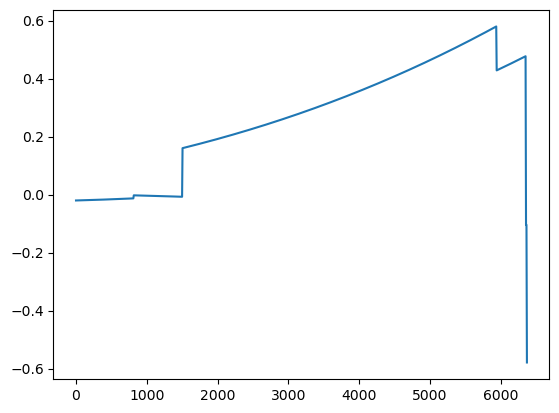

In [6]:
true_model = functions.Random_1D(domain=EarthDomain, seed=1)
%matplotlib inline
true_model.plot()

data = G.map(true_model)

Now we obtain the least norm solution

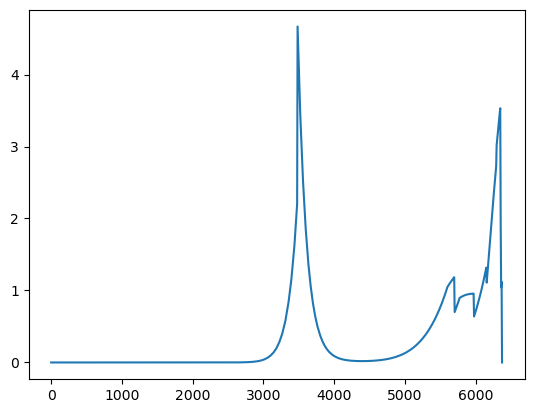

In [7]:
plt.plot(EarthDomain.mesh, sensitivity_kernels[50].evaluate(EarthDomain.mesh))

In [19]:
N=100
scipy.integrate.simps(sensitivity_kernels[50].evaluate(EarthDomain.dynamic_mesh(N)), EarthDomain.dynamic_mesh(N))

2102.8540414785293

In [30]:
scipy.integrate.quad(sensitivity_kernels[50].evaluate, EarthDomain.bounds[0][0], EarthDomain.bounds[0][1], limit=100)

/tmp/ipykernel_28859/737783537.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scipy.integrate.quad(sensitivity_kernels[50].evaluate, EarthDomain.bounds[0][0], EarthDomain.bounds[0][1])


(2206.7830475345595, 34.383670330014866)

In [10]:
M.inner_product(sensitivity_kernels[0], sensitivity_kernels[0])

/home/adrian/PhD/BGSOLA/SOLA_DLI/sola/main_classes/spaces.py:266: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(


6779.696641067551

In [11]:
# Find pseudo-inverse
G_adjoint = G.adjoint
# Normally we would now compute this
"""G_pseudo_inverse = G_adjoint * (G * G_adjoint).invert()"""
# But computing (G * G_adjoint) is equivalent to computing the associated Gram
# matrix for the G mapping  which can be done faster with the method
# "_compute_GramMatrix()". The resulting Gram matrix can then be used to form a
# FiniteLinearMapping:
print('a')
Lambda = G._compute_GramMatrix()
print('b')
# Now we invert Lambda
Lambda_inv = Lambda.invert()
# And finally find the least norm solution
least_norm_solution = G_adjoint.map(Lambda_inv.map(data))
# And we plot it
plt.plot(EarthDomain.mesh,
         least_norm_solution.evaluate(EarthDomain.mesh)[1])

a


KeyboardInterrupt: 

Now we want to compute the Resolving kernels. For this we need the X matrix: 

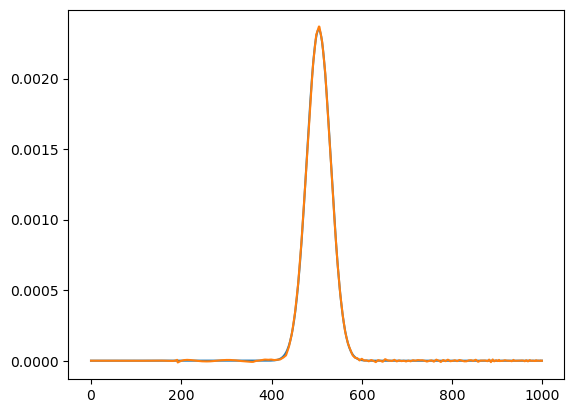

In [ ]:
Gamma = T * G_adjoint
X = Gamma * Lambda_inv
resolving_kernels = np.dot(X.matrix, sensitivity_kernels)
%matplotlib inline
# Choose what resolving kernel to plot below
plt.figure(1)
plt.plot(target_kernels[50].evaluate(EarthDomain.mesh)[1])
plt.plot(resolving_kernels[50].evaluate(EarthDomain.mesh)[1])
plt.show()

And we compute the least norm solution property

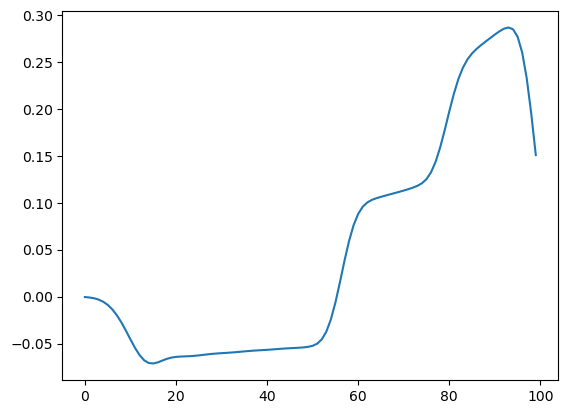

In [ ]:
least_norm_property = X.map(data)

plt.plot(least_norm_property)

To compute the bounds we will need the diagonal of $\mathcal{H} = \chi - \Gamma \Lambda^{-1} \Gamma^*$ matrix, which are simply $\int (T_i - A_i)^2$ and a norm Bound $M$. Let's start by computing a norm bound using piecewise functions.

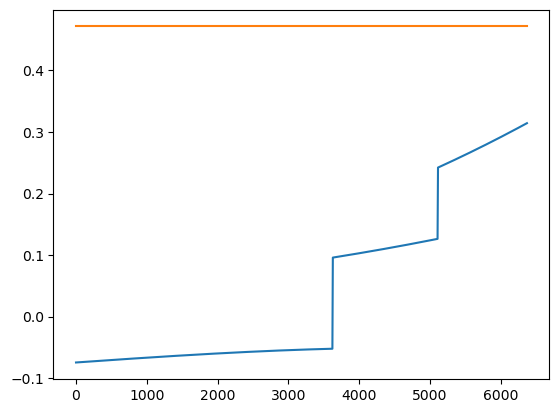

37.63352554843237 11.236865257388734


In [ ]:
intervals = np.array([0, EarthDomain.bounds[0][1]])
values = true_model.evaluate(intervals[1:])[1] * 1.5
upper_bound_function = Piecewise_1D(domain=EarthDomain,
                 intervals=intervals,
                 values=values)
plt.figure()
plt.plot(EarthDomain.mesh, true_model.evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, upper_bound_function.evaluate(EarthDomain.mesh)[1])
plt.show()

norm_bound = M.norm(upper_bound_function)
least_norm = M.norm(least_norm_solution)
print(norm_bound, least_norm)

In [ ]:
bounds = []
for resolving, target in zip(resolving_kernels, target_kernels):
    H_diag = M.norm(target - resolving)
    bound = np.sqrt((norm_bound**2 - least_norm**2))*H_diag
    bounds.append(bound)
bounds = np.array(bounds).reshape((no_targets, 1))

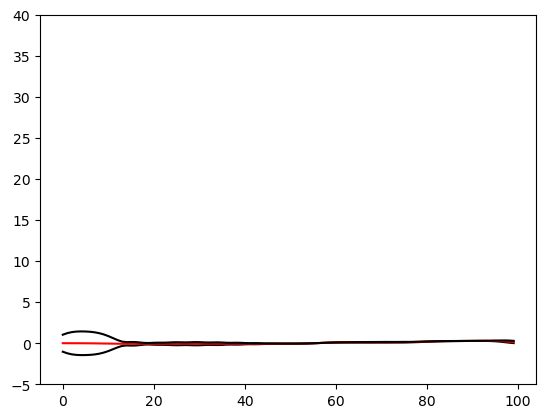

In [ ]:
plt.figure(2)
plt.plot(least_norm_property - bounds, color='black')
plt.plot(least_norm_property, color='red')
plt.plot(least_norm_property + bounds, color='black')
plt.ylim(-5,40)
plt.show()